**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**

# Goal of this notebook

This notebook introduces the **Runge phenomenon** and uses it to motivate a central idea in modern deep learning:

> **Overparameterized neural networks tend to produce smooth function approximations.**

The goal is twofold:

1. To illustrate how **polynomial interpolation** can generate severe oscillations even when the target function is smooth.
2. To contrast this behavior with **overparameterized neural networks**, which often converge to smooth solutions despite having far more parameters than data points.

In one of my papers I used this fact in one of my papers [Spooky Boundaries at a Distance: Inductive Bias, Dynamic Models, and Behavioral Macro](https://www.nber.org/papers/w32850).

This perspective is particularly relevant for value function approximation in dynamic economic models.

---

## General setup

Let $f : [-1,1] \to \mathbb{R}$ be a smooth function. A classical approach to approximation is to use a degree-$n$ polynomial $p_n$ that interpolates $f$ at $n+1$ equally spaced nodes:

$$
p_n(x_i) = f(x_i), \quad x_i = -1 + \frac{2i}{n}, \quad i = 0, \dots, n.
$$

Although $f$ is smooth, the interpolating polynomial $p_n$ can exhibit large oscillations near the boundary of the domain as $n$ increases.

---

## The Runge phenomenon

A canonical example is the **Runge function**

$$
f(x) = \frac{1}{1 + 25x^2}.
$$

Despite being infinitely differentiable, polynomial interpolation at equally spaced points produces oscillatory behavior that worsens with the degree of the polynomial.


## Polynomial Interpolation

In [1]:
## Importing packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
## Runge function
def runge(x):
    return 1 / (1 + 25 * x**2)

def poly_interpolation_runge(n):
    # Equally spaced interpolation nodes
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = runge(x_nodes)
    # Polynomial interpolation (Vandermonde / exact interpolation)
    coeffs = np.polyfit(x_nodes, y_nodes, deg=n)
    p = np.poly1d(coeffs)
    return x_nodes, y_nodes, p

In [3]:
## Degree of the polynomial
n_poly = 10  # degree-10 polynomial → 11 interpolation points
x_train_np, y_train_np, p = poly_interpolation_runge(n = n_poly)

In [4]:
## Test data
x_test_np = np.linspace(-1, 1, 1000)
y_true_np = runge(x_test_np)
y_test_poly_np = p(x_test_np)

In [5]:
fontsize= 14
ticksize = 14
figsize = (8, 6)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

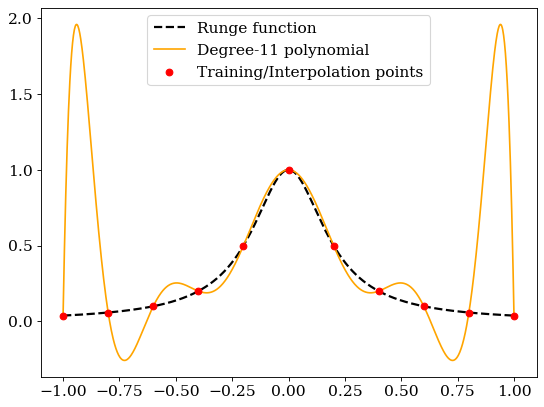

In [6]:
plt.plot(x_test_np, y_true_np, label="Runge function", color ="k", linestyle="--" , linewidth=2)
plt.plot(x_test_np, y_test_poly_np, color = "orange", label="Degree-11 polynomial")
plt.scatter(x_train_np, y_train_np, color="r", zorder=3, label="Training/Interpolation points")
plt.legend(loc = "upper center")

## Deep Learning Implementation

#### Defining the neural network


In [7]:
class NN(nn.Module):
    def __init__(self,
                 input_dim = 1,
                 dim_hidden=128,
                 layers=2,
                 hidden_bias=True,
                 hidden_activation=nn.Tanh,
                 seed=123):
        super().__init__()
        self.input_dim = input_dim
        self.dim_hidden = dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        self.hidden_activation = hidden_activation
        self.seed = seed

        # Set seed if provided
        if self.seed is not None:
            torch.manual_seed(self.seed)
        
        module = []
        
        # First layer
        module.append(nn.Linear(self.input_dim, self.dim_hidden, bias=self.hidden_bias))
        module.append(self.hidden_activation())

        # Additional hidden layers
        for _ in range(self.layers - 1):
            module.append(nn.Linear(self.dim_hidden, self.dim_hidden, bias=self.hidden_bias))
            module.append(self.hidden_activation())

        module.append(nn.Linear(self.dim_hidden, 1))

        self.q = nn.Sequential(*module)

    def forward(self, x):
        return self.q(x)

#### Training data and data loader

In [8]:
x_train = torch.from_numpy(x_train_np).float().unsqueeze(dim = 1)
y_train = torch.from_numpy(y_train_np).float().unsqueeze(dim = 1)

train_dataset = TensorDataset(x_train, y_train)
batch_size = len(x_train)
# Create dataloader
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)

In [9]:
num_epochs = 301
print_freq = 100

#### Initializing the neural network

In [10]:
model = NN()

### Setting the optimizer

In [11]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)

#### Mean-squared loss function

In [12]:
criterion = nn.MSELoss()


#### Training loop

In [13]:
for epoch in range(num_epochs):
    for x,y in train_loader:
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    scheduler.step()  
    if (epoch) % print_freq == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')


        

Epoch [1/301], Loss: 0.20817570
Epoch [101/301], Loss: 0.02765144
Epoch [201/301], Loss: 0.00914267
Epoch [301/301], Loss: 0.00050452


In [14]:
x_test = torch.from_numpy(x_test_np).float().unsqueeze(dim = 1)

In [15]:
model.eval()
y_test_DL = model(x_test).detach()

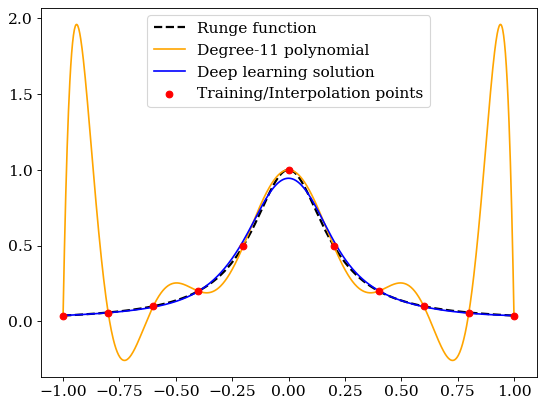

In [16]:
plt.plot(x_test_np, y_true_np, label="Runge function", color ="k", linestyle="--" , linewidth=2)
plt.plot(x_test_np, y_test_poly_np, color = "orange", label="Degree-11 polynomial")
plt.plot(x_test, y_test_DL, color = "blue", label="Deep learning solution")
plt.scatter(x_train_np, y_train_np, color="r", zorder=3, label="Training/Interpolation points")
plt.legend(loc = "upper center")